<a href="https://colab.research.google.com/github/d-maniatakos/vaccine-sentiment-classifier/blob/master/vaccine_sentiment_classifier_using_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vaccine Sentiment Classifier using Recurrent Neural Networks (LSTM/GRU)**


## **Modules Import**

In [2]:
import pandas as pd
import numpy as np


import torch
from torch import nn
from torch.utils.data import DataLoader

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Glove Download & Dictionary Creation**


In [3]:
# don't run this cell if file "glove.6B.100d.txt" already exists

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-01-17 14:57:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-17 14:57:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-17 14:57:47--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [4]:
glove = {}

# read file line by line while creating glove dictionary
with open('glove.6B.100d.txt') as f:
    lines = f.readlines()
for line in lines:
  vector = []
  for dim in line.split(' ')[1:]:
    vector.append(float(dim))
  glove[line.split(' ')[0]] = np.array(vector)

## **Data Import**


In [5]:
# read datasets and ignore the first (index) column
train_data =  pd.read_csv('vaccine_train_set.csv').iloc[:, 1:]
validation_data = pd.read_csv('vaccine_validation_set.csv').iloc[:, 1:]    # <--- replace with test set path

negative_train_tweets =  train_data[train_data['label'] == 1]

# some upsampling of netagive tweets to deal with the umbalanced ratio
train_data = train_data.append(negative_train_tweets)

train_data.head()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


## **Pre-processing & Vectorization**


In [6]:
# preprocess tweets texts before vectorization
def preprocess(text):
  text = text.lower()
  unwanted_chars = ['@', '#', '!', '(', ')', '*', ':', ',']

  for char in unwanted_chars:
    text = text.replace(char, '')

  return text


def padding(original_list, element, length):
  if len(original_list) > length:
    return original_list[:length]
  else:
    new_list = original_list.copy()
    for i in range(len(original_list), length):
      new_list.append(element)
    return new_list


# vectorize a tweet using glove word embedding
def glove_sequence(corpus):
  sequences = []

  for document in corpus:
    sequence = []

    for token in document.split():
      try:
        sequence.append(list(glove[token]))
      except:
        pass

    sequence = padding(sequence, list(np.zeros(100)), 100)
    sequences.append(sequence)
    
  return sequences



train_data['tweet'] = train_data['tweet'].apply(preprocess)
validation_data['tweet'] = validation_data['tweet'].apply(preprocess)

train_corpus = train_data['tweet']
validation_corpus = validation_data['tweet']

x_train = glove_sequence(['review review review', 'good good good', 'review review review', 'good good good'])

## **LSTM Model Creation**

In [10]:
class LSTM(nn.Module):
  def __init__(self, x_size, hidden_size, num_of_classes, num_of_layers):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(x_size, hidden_size, num_of_layers, bidirectional=True, dropout=0.6, batch_first=True)
    self.fc = nn.Linear(hidden_size*2, num_of_classes)

  def forward(self, x):
    out, (hidden, cell) = self.lstm(x)
    out = torch.mean(out, dim=1)
    out = self.fc(out)
    return out

## **LSTM Model Training**

In [18]:
x_train = torch.Tensor(glove_sequence(train_corpus))
y_train = torch.tensor(train_data['label'].values, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

x_size = 100
hidden_size = 25
num_of_classes = 3
num_of_layers = 3
learning_rate = 0.01
num_of_epochs = 5
loss_function = nn.CrossEntropyLoss()

model = LSTM(x_size, hidden_size, num_of_classes, num_of_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


model.train()

training_loss = []
validation_loss = []

for epoch in range(num_of_epochs):
  batch_losses = []
  
  for index, (x, y) in enumerate(train_dataloader):
    y_pred = model(x)
    loss = loss_function(y_pred, y)
    batch_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  x_validation = torch.Tensor(glove_sequence(validation_corpus))
  y_validation = list(validation_data['label'].values)
  val_pred = model(x_validation)
  val_loss = loss_function(val_pred, torch.tensor(y_validation, dtype=torch.long))
  print('Epoch: ' + str(epoch+1) + '/' + str(num_of_epochs) + ' Training Loss: ' + str(round(sum(batch_losses)/len(train_dataloader), 4)) + ' Validation Loss: ' + str(round(val_loss.item(), 4)))
  validation_loss.append(val_loss.item())
  training_loss.append(sum(batch_losses)/len(train_dataloader))


Epoch: 1/5 Training Loss: 0.9222 Validation Loss: 0.8578
Epoch: 2/5 Training Loss: 0.835 Validation Loss: 0.8162
Epoch: 3/5 Training Loss: 0.7944 Validation Loss: 0.8552
Epoch: 4/5 Training Loss: 0.7619 Validation Loss: 0.7466
Epoch: 5/5 Training Loss: 0.7202 Validation Loss: 0.7604


## **LSTM Model Evaluation**

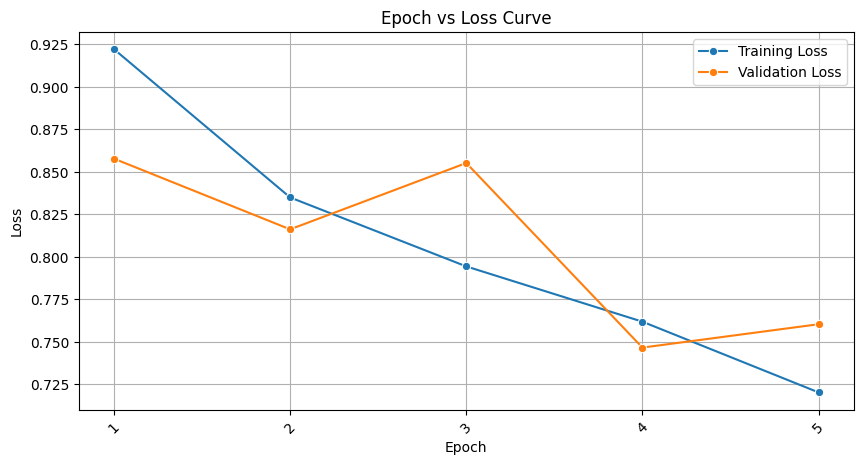

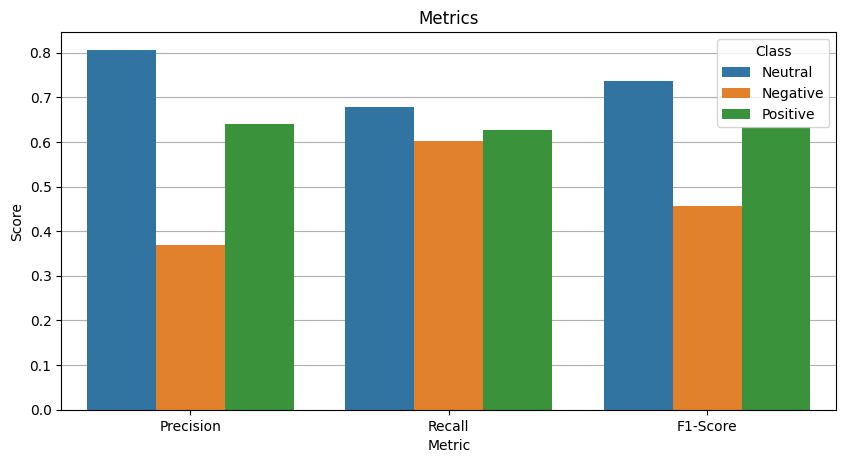

Total Precision: 0.6822030168204112
Total Recall: 0.6476774758983348
Total F1-Score: 0.6587191687066315


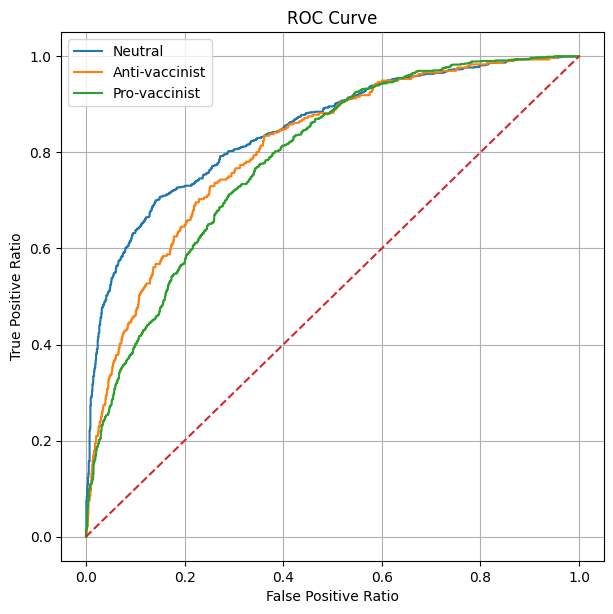

In [19]:
def compute_metrics(predictions, real_values):
  precisions = []
  recalls = []
  f1_scores = []

  for i in range(3):
    class_preds = list(map(lambda x: 1 if x==i else 0, predictions))
    class_values = list(map(lambda x: 1 if x==i else 0, real_values))
    precisions.append(precision_score(class_values, class_preds))
    recalls.append(recall_score(class_values, class_preds))
    f1_scores.append(f1_score(class_values, class_preds))

  scores_df = pd.DataFrame({'Metric' : ['Precision' , 'Precision', 'Precision', 'Recall', 'Recall', 'Recall', 'F1-Score', 'F1-Score', 'F1-Score'], 
                            'Class' : ['Neutral', 'Negative', 'Positive', 'Neutral', 'Negative', 'Positive', 'Neutral', 'Negative', 'Positive'],
                            'Score' : precisions + recalls + f1_scores})
  
  plt.figure(figsize=(10, 5), dpi=100)
  plt.title('Metrics')
  plt.rc('axes', axisbelow=True)
  plt.grid(zorder=0)
  sns.barplot(y='Score', x='Metric', hue='Class', data=scores_df)
  plt.show()

  print('Total Precision: ' + str(precision_score(real_values, predictions, average='weighted')))
  print('Total Recall: ' + str(recall_score(real_values, predictions, average='weighted')))
  print('Total F1-Score: ' + str(f1_score(real_values, predictions, average='weighted')))

def plot_roc_curve(prediction_scores, y_validation):
  plt.figure(figsize=(7, 7), dpi=100)
  plt.grid()
  plt.xlabel('False Positive Ratio')
  plt.ylabel('True Positive Ratio')
  plt.title('ROC Curve')
  y_validation_binarized = label_binarize(y_validation, classes=[0, 1, 2])

  fpr, tpr, _ = roc_curve(y_validation_binarized[:, 0], [score[0] for score in predictions_scores.tolist()])
  plt.plot(fpr, tpr)

  fpr, tpr, _ = roc_curve(y_validation_binarized[:, 1], [score[1] for score in predictions_scores.tolist()])
  plt.plot(fpr, tpr)

  fpr, tpr, _ = roc_curve(y_validation_binarized[:, 2], [score[2] for score in predictions_scores.tolist()])
  plt.plot(fpr, tpr)

  #add a reference y=x line
  plt.plot([0, 1], [0, 1], linestyle='dashed')

  plt.legend(['Neutral', 'Anti-vaccinist', 'Pro-vaccinist'])

  plt.show()

def plot_epoch_vs_loss(num_of_epochs, training_loss, validation_loss):
  plt.figure(figsize=(10, 5), dpi=100)
  plt.title('Epoch vs Loss Curve')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  sns.lineplot(x=range(1, num_of_epochs+1), y=training_loss,  marker="o")
  sns.lineplot(x=range(1, num_of_epochs+1), y=validation_loss,  marker="o")
  plt.xticks(range(1, num_of_epochs+1))
  plt.xticks(rotation=45)
  plt.legend(['Training Loss', 'Validation Loss'])
  plt.grid()
  plt.show()


model.eval()

predictions_scores = model(x_validation)
predictions = torch.argmax(predictions_scores, dim=1).tolist()

plot_epoch_vs_loss(num_of_epochs, training_loss, validation_loss)

compute_metrics(predictions, y_validation)

plot_roc_curve(predictions_scores, y_validation)


## **GRU Model Creation**

In [20]:
class GRU(nn.Module):
  def __init__(self, x_size, hidden_size, num_of_classes, num_of_layers):
    super(GRU, self).__init__()
    self.hidden_size = hidden_size

    self.lstm = nn.GRU(x_size, hidden_size, num_of_layers, bidirectional=True, dropout=0.5, batch_first=True)
    self.fc = nn.Linear(hidden_size*2, num_of_classes)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = torch.mean(out, dim=1)
    out = self.fc(out)
    return out

## **GRU Model Training**

In [21]:
x_size = 100
hidden_size = 25
num_of_classes = 3
num_of_layers = 2
learning_rate = 0.01
num_of_epochs = 5
loss_function = nn.CrossEntropyLoss()

model = GRU(x_size, hidden_size, num_of_classes, num_of_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

training_loss = []
validation_loss = []

model.train()

for epoch in range(num_of_epochs):
  batch_losses = []
  for index, (x, y) in enumerate(train_dataloader):
    y_pred = model(x)
    loss = loss_function(y_pred, y)
    batch_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  x_validation = torch.Tensor(glove_sequence(validation_corpus))
  y_validation = list(validation_data['label'].values)
  val_pred = model(x_validation)
  val_loss = loss_function(val_pred, torch.tensor(y_validation, dtype=torch.long))
  print('Epoch: ' + str(epoch+1) + '/' + str(num_of_epochs) + ' Training Loss: ' + str(round(sum(batch_losses)/len(train_dataloader), 4)) + ' Validation Loss: ' + str(round(val_loss.item(), 4)))
  validation_loss.append(val_loss.item())
  training_loss.append(sum(batch_losses)/len(train_dataloader))


Epoch: 1/5 Training Loss: 0.8778 Validation Loss: 0.8336
Epoch: 2/5 Training Loss: 0.7591 Validation Loss: 0.7441
Epoch: 3/5 Training Loss: 0.7012 Validation Loss: 0.736
Epoch: 4/5 Training Loss: 0.6534 Validation Loss: 0.759
Epoch: 5/5 Training Loss: 0.626 Validation Loss: 0.7669


## **GRU Model Evaluation**

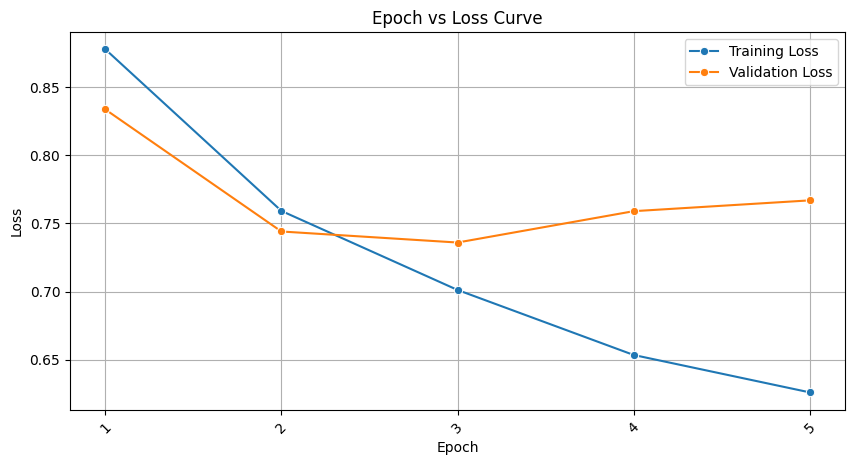

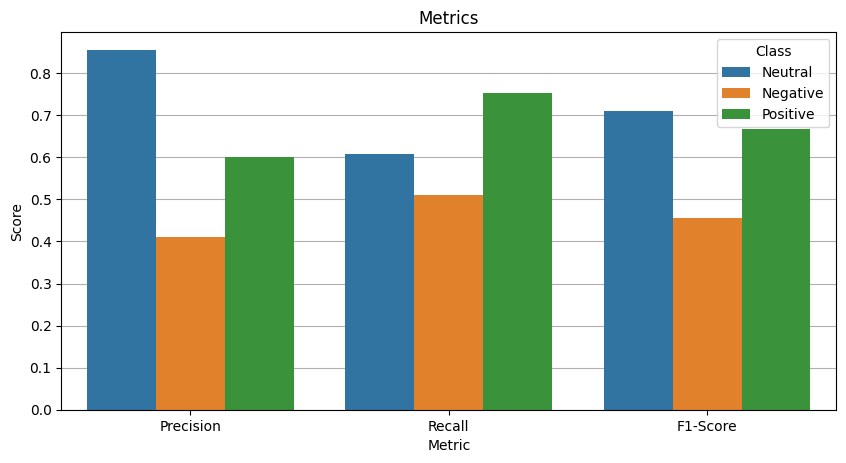

Total Precision: 0.6941900537389061
Total Recall: 0.6538124452234881
Total F1-Score: 0.6600265250892534


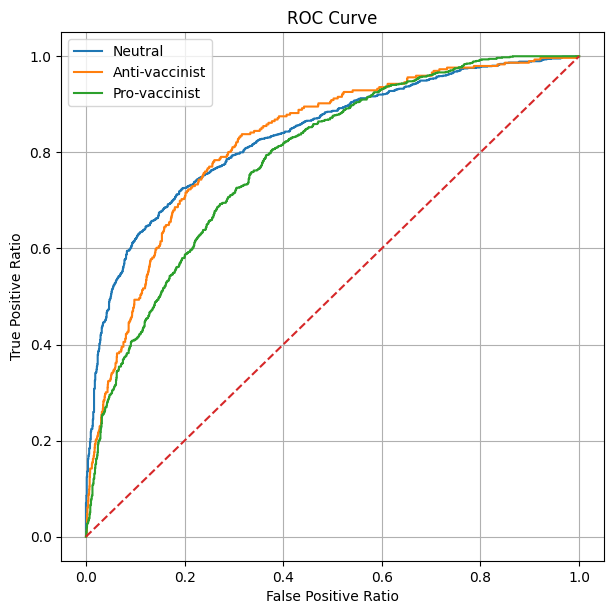

In [22]:
model.eval()

predictions_scores = model(x_validation)
predictions = torch.argmax(predictions_scores, dim=1).tolist()

plot_epoch_vs_loss(num_of_epochs, training_loss, validation_loss)

compute_metrics(predictions, y_validation)

plot_roc_curve(predictions_scores, y_validation)